In [2]:
# Essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
# Preprocessing utilities
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

sys.path.append('..')

# Logging
import logging
from src.utils.logger import setup_logger

# Logger setup
logger = setup_logger('preprocessing_logger', '../logs/preprocessing.log')


In [3]:
# Load datasets
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
store = pd.read_csv('../data/store.csv')

logger.info("Data successfully loaded.")

C:\Users\hp\AppData\Local\Temp\ipykernel_12212\3760184203.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('../data/train.csv')
2025-01-14 04:00:39,997 - preprocessing_logger - INFO - Data successfully loaded.


In [4]:
# Merge train/test with store data
train = train.merge(store, on='Store', how='left')
test = test.merge(store, on='Store', how='left')

logger.info("Datasets merged. Train shape: {}, Test shape: {}".format(train.shape, test.shape))


2025-01-14 04:00:57,902 - preprocessing_logger - INFO - Datasets merged. Train shape: (1017209, 18), Test shape: (41088, 17)


In [5]:
# Check missing values
missing_train = train.isnull().sum()
missing_test = test.isnull().sum()
logger.info("Missing values in train:\n{}".format(missing_train[missing_train > 0]))
logger.info("Missing values in test:\n{}".format(missing_test[missing_test > 0]))

# Impute missing values
imputer = SimpleImputer(strategy='median')
train[['CompetitionDistance']] = imputer.fit_transform(train[['CompetitionDistance']])
test[['CompetitionDistance']] = imputer.transform(test[['CompetitionDistance']])

logger.info("Missing values imputed.")


2025-01-14 04:01:08,416 - preprocessing_logger - INFO - Missing values in train:
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64
2025-01-14 04:01:08,421 - preprocessing_logger - INFO - Missing values in test:
Open                            11
CompetitionDistance             96
CompetitionOpenSinceMonth    15216
CompetitionOpenSinceYear     15216
Promo2SinceWeek              17232
Promo2SinceYear              17232
PromoInterval                17232
dtype: int64
2025-01-14 04:01:08,798 - preprocessing_logger - INFO - Missing values imputed.


In [6]:
# Convert Date to datetime
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

# Extract features
train['Weekday'] = train['Date'].dt.weekday
test['Weekday'] = test['Date'].dt.weekday

train['IsWeekend'] = train['Weekday'] >= 5
test['IsWeekend'] = test['Weekday'] >= 5

train['Month'] = train['Date'].dt.month
test['Month'] = test['Date'].dt.month

train['MonthPhase'] = np.where(train['Date'].dt.day <= 10, 'Beginning',
                        np.where(train['Date'].dt.day <= 20, 'Mid', 'End'))
test['MonthPhase'] = np.where(test['Date'].dt.day <= 10, 'Beginning',
                        np.where(test['Date'].dt.day <= 20, 'Mid', 'End'))

# Custom Features
train['DaysToHoliday'] = train['SchoolHoliday'].shift(-1) - train['SchoolHoliday']
test['DaysToHoliday'] = test['SchoolHoliday'].shift(-1) - test['SchoolHoliday']

logger.info("Feature engineering completed.")


2025-01-14 04:01:25,433 - preprocessing_logger - INFO - Feature engineering completed.


In [7]:
# Encoding categorical variables
train = pd.get_dummies(train, columns=['StateHoliday', 'StoreType', 'Assortment', 'MonthPhase'], drop_first=True)
test = pd.get_dummies(test, columns=['StateHoliday', 'StoreType', 'Assortment', 'MonthPhase'], drop_first=True)

logger.info("Categorical encoding completed.")


2025-01-14 04:01:37,463 - preprocessing_logger - INFO - Categorical encoding completed.


In [10]:
# Numeric columns for train and test
train_numeric_cols = ['Sales', 'Customers', 'CompetitionDistance']
test_numeric_cols = ['CompetitionDistance']

# Initialize separate scalers
scaler_train = StandardScaler()
scaler_test = StandardScaler()

# Scale train numeric columns
train[train_numeric_cols] = scaler_train.fit_transform(train[train_numeric_cols])

# Scale test numeric columns (fit only on available columns)
test[test_numeric_cols] = scaler_test.fit_transform(test[test_numeric_cols])

logger.info("Feature scaling completed without errors.")


2025-01-14 04:03:36,022 - preprocessing_logger - INFO - Feature scaling completed without errors.


In [11]:
# Save preprocessed data
train.to_csv('../data/processed_train.csv', index=False)
test.to_csv('../data/processed_test.csv', index=False)

logger.info("Preprocessed data saved.")


2025-01-14 04:05:31,099 - preprocessing_logger - INFO - Preprocessed data saved.


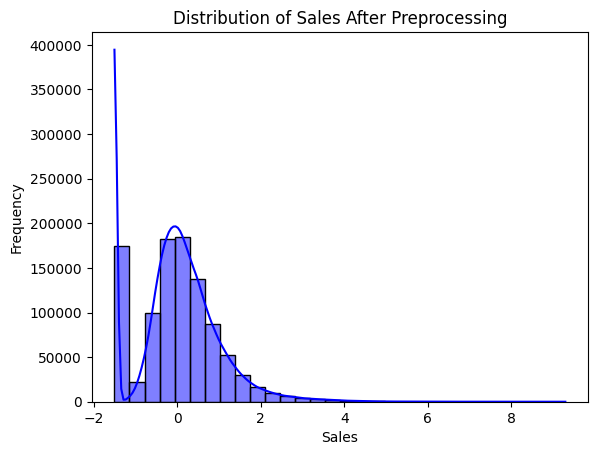

In [12]:
sns.histplot(train['Sales'], kde=True, bins=30, color='blue')
plt.title('Distribution of Sales After Preprocessing')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()


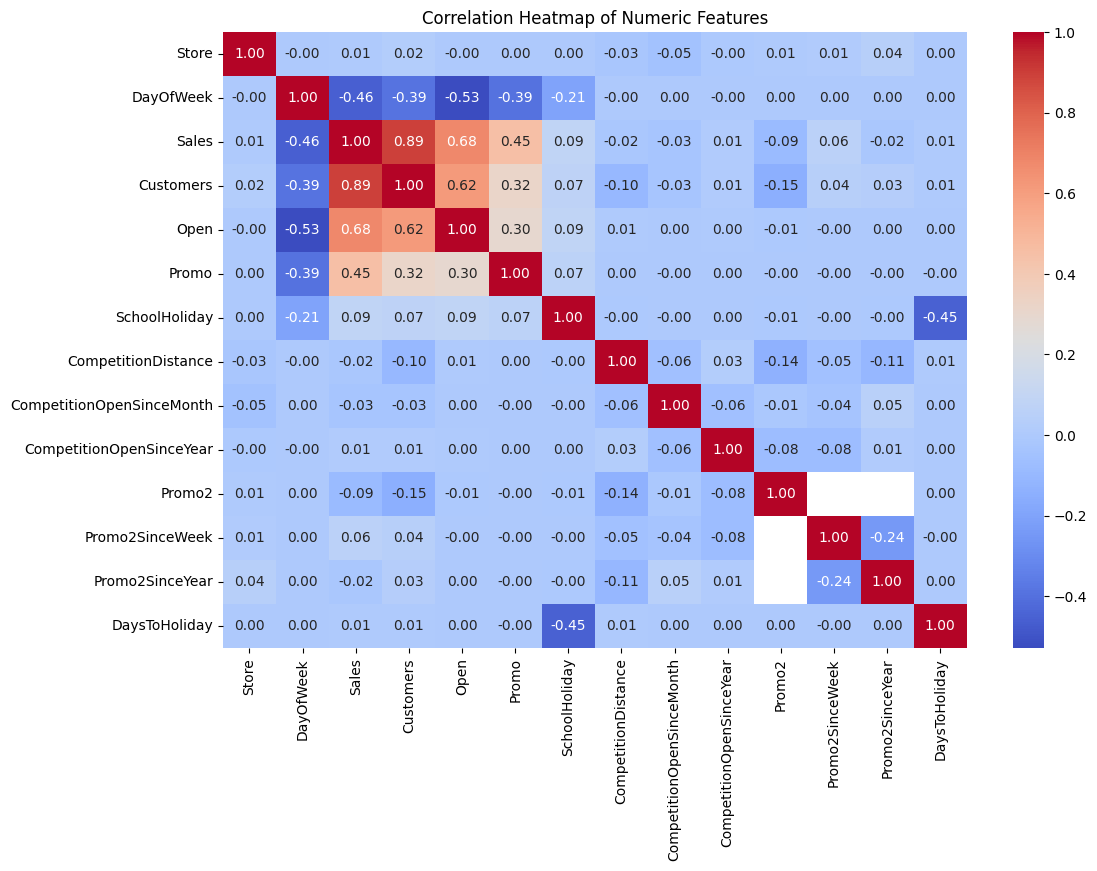

In [14]:
# Select only numeric columns
numeric_train = train.select_dtypes(include=['float64', 'int64'])

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_train.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


In [16]:
# Separate features and target variable
X = train.drop(columns=['Sales', 'Date'])
y = train['Sales']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

logger.info(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")


2025-01-14 04:09:25,188 - preprocessing_logger - INFO - Train shape: (813767, 28), Validation shape: (203442, 28)


In [17]:
# Define the pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
    ('scaler', StandardScaler()),                  # Standardize features
    ('model', RandomForestRegressor(random_state=42))  # Model
])

logger.info("Pipeline successfully created.")


2025-01-14 04:09:34,706 - preprocessing_logger - INFO - Pipeline successfully created.


In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Identify columns
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Preprocessing for numeric data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
    ('scaler', StandardScaler())                   # Scale features
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))    # Encode
])

# Combine preprocessing for numeric and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [21]:
# Combine preprocessor with the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])


In [23]:
# Subset the data for faster experimentation
X_train_small = X_train.sample(frac=0.1, random_state=42)
y_train_small = y_train.loc[X_train_small.index]

# Fit the pipeline on the smaller subset
pipeline.fit(X_train_small, y_train_small)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Store', 'DayOfWeek', 'Customers', 'Open', 'Promo', 'SchoolHoliday',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'DaysToHoliday'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['PromoInterval'], dtype='object'))])),
                ('model', RandomForestRegressor(random_state=42))])

In [24]:
from sklearn.metrics import mean_absolute_error

# Predict on validation set
y_pred = pipeline.predict(X_val)

# Compute MAE
mae = mean_absolute_error(y_val, y_pred)
print(f"Validation Mean Absolute Error: {mae:.2f}")


Validation Mean Absolute Error: 0.11


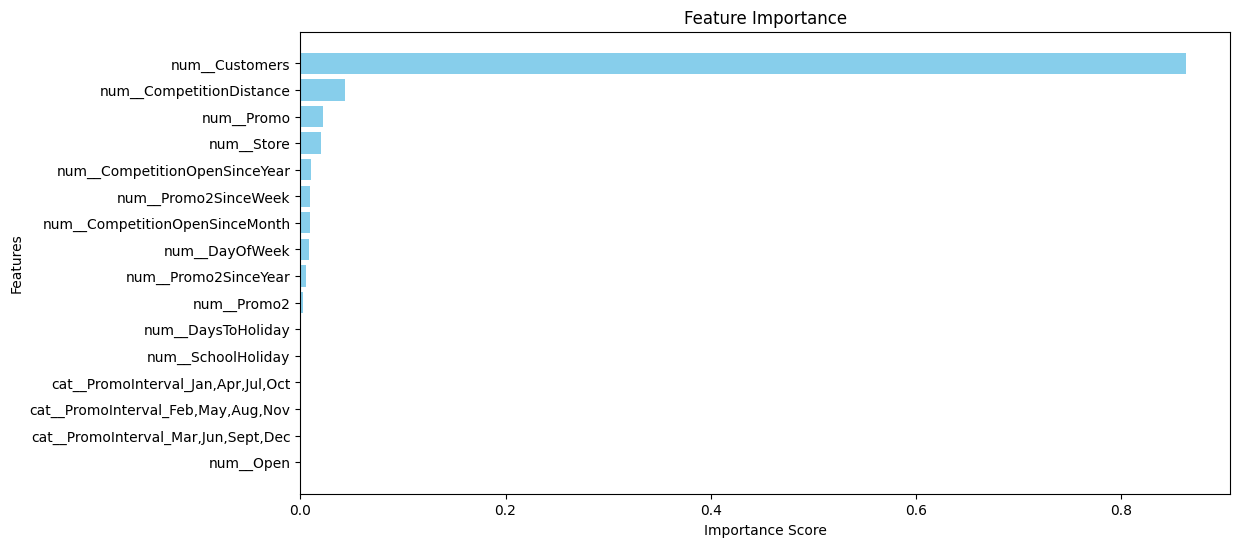

In [25]:
# Extract feature importance
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importance from the model
feature_importance = pipeline.named_steps['model'].feature_importances_
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


In [28]:
# Preprocess training and validation data once
X_train_preprocessed = pipeline.named_steps['preprocessor'].transform(X_train_small)
X_val_preprocessed = pipeline.named_steps['preprocessor'].transform(X_val)


In [29]:
from sklearn.utils import resample 
# Initialize a lightweight Random Forest model
light_model = RandomForestRegressor(n_estimators=10, max_depth=5, random_state=42)

# Bootstrap confidence intervals
n_bootstraps = 30
bootstrap_preds = np.zeros((len(y_val), n_bootstraps))

for i in range(n_bootstraps):
    # Resample the preprocessed training data
    X_resampled, y_resampled = resample(X_train_preprocessed, y_train_small, random_state=i)
    
    # Fit the model on resampled data
    light_model.fit(X_resampled, y_resampled)
    
    # Make predictions on preprocessed validation data
    bootstrap_preds[:, i] = light_model.predict(X_val_preprocessed)

# Calculate prediction intervals
lower_bound = np.percentile(bootstrap_preds, 5, axis=1)
upper_bound = np.percentile(bootstrap_preds, 95, axis=1)

# Display intervals
intervals_df = pd.DataFrame({
    'Actual': y_val.values,
    'Predicted': y_pred,
    'Lower Bound': lower_bound,
    'Upper Bound': upper_bound
})

print(intervals_df.head())


     Actual  Predicted  Lower Bound  Upper Bound
0 -1.499723  -1.499723    -1.499723    -1.499723
1 -0.058655   0.328513     0.459855     0.714582
2  0.439796   0.608545     0.665784     0.783687
3 -0.626978  -0.529327    -0.687351    -0.598431
4  1.465011   1.193094     0.669451     0.756194


In [30]:
import joblib
import datetime

# Save the model with a timestamp
timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
model_filename = f"../logs/sales_model_{timestamp}.pkl"

joblib.dump(pipeline, model_filename)
print(f"Model saved as: {model_filename}")


Model saved as: ../logs/sales_model_2025-01-14-05-01-50.pkl


In [45]:
import joblib

# The timestamp you provided
timestamp = "2025-01-14-05-01-50"  # The timestamp from the saved model filename
model_filename = f"../logs/sales_model_{timestamp}.pkl"  # Construct the full model filename

# Load the saved model
loaded_model = joblib.load(model_filename)
print(f"Model loaded from: {model_filename}")

# Inspect the steps of the pipeline
print("Steps in the pipeline:")
print(loaded_model.named_steps)

# If you want to access a specific step, make sure to use the correct name.
# For example, if the step is called 'preprocessor', use 'preprocessor' instead of 'columntransformer'


Model loaded from: ../logs/sales_model_2025-01-14-05-01-50.pkl
Steps in the pipeline:
{'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 Index(['Store', 'DayOfWeek', 'Customers', 'Open', 'Promo', 'SchoolHoliday',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'DaysToHoliday'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknow